# Classifying the Text of Reddit Posts by Fine Tuning Transformers

In this notebook, I classify Reddit post titles + text into 'Conservative' or 'Liberal' posts. To accomplish this, I fine tune a pretrained model (downloaded from HuggingFace).

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.

In [1]:
# imports and installs

import numpy as np
import pandas as pd
import os

!pip install -U transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [2]:
# load data into HuggingFace dataset

from datasets import load_dataset
dataset = load_dataset('csv', data_files='../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc9590c0949f0926/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# change dataset to pandas dataframe to prepare data
# drop irrelevant columns and null values and shuffle dataset

dataset.set_format(type="pandas")
df = dataset["train"][:]
df = df.dropna()
df = df.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments','Date Created'])
df.sample(frac=1)

,Title,Political Lean,Text
10309,Do libertarians tend to conflate socialism wit...,Conservative,The vibe I get from libertarians is that socia...
5373,Create a tax system and an economy,Liberal,I don't know if this question was asked before...
10696,Should schools provide free school lunch progr...,Conservative,"In the United States, over [11 million childre..."
4059,Ukrainian socialists and social-democrats,Liberal,Are there any fellow socialists from Ukraine o...
4819,Rhine Capitalism or Nordic Model?,Liberal,I was just curious for someone perhaps who had...
...,...,...,...
374,Would anyone like to be interview for a school...,Liberal,I am currently in high school and I am studyin...
4312,How does universal childcare work in a Social ...,Liberal,"Hello all, I know that the general consensus h..."
4668,A Goverment Roleplay,Liberal,So normally i would do this but this time arou...
7890,Communist Youtube,Liberal,I love the fact I am watching YouTube and lite...


In [4]:
# concatenate text & title features, doubling the title to represent increased importance
# take a look at one sample from the new column

df["total_text"] = df["Title"] + " " + df["Title"] + " " + df["Text"]
df = df.drop(columns=['Title', 'Text'])
df['total_text'][11]

"Be careful when you post to r/politics and r/askreddit - trolls are trying to get you banned Be careful when you post to r/politics and r/askreddit - trolls are trying to get you banned I have fallen for this trap several times and got temp banned in both these subreddits. Trolls will goat you on and you end saying something less than civil. They then report your comment, and delete theirs. It makes it look like you are the one being uncivil. You end up getting banned. \n\nIt's my own fault for saying what I did, and will serve my sentence. I mean we all should be civil regardless. But know their goal is not to debate. It's to get you banned."

In [5]:
# encode labels

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["Political Lean"])
df["Political Lean"] = le.transform(df["Political Lean"])

In [6]:
# convert back into HuggingFace dataset and rename label column

from datasets import Dataset

politics = Dataset.from_pandas(df)
politics = politics.rename_column("Political Lean", "label")

In [7]:
# split the data into 90% train, 5% val, and 5% test
train_test = politics.train_test_split(test_size=0.1)
test_valid = train_test['test'].train_test_split(test_size=0.5)

# gather splits into single dataset
from datasets import DatasetDict
politics = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
politics = politics.remove_columns(['__index_level_0__'])
politics

DatasetDict({
    train: Dataset({
        features: ['label', 'total_text'],
        num_rows: 2185
    })
    test: Dataset({
        features: ['label', 'total_text'],
        num_rows: 122
    })
    valid: Dataset({
        features: ['label', 'total_text'],
        num_rows: 121
    })
})

In [8]:
# tokenizing the text from pretrained model

from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [9]:
# tokenize all data

def tokenize(batch):
    return tokenizer(batch["total_text"], padding=True, truncation=True, max_length=400)

politics_encoded = politics.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
# downloading pretrained model for classification

from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to("cuda"))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [11]:
# defining a function to compute metrics during model training

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [12]:
# preparing arguments to train the model

from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(politics_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-politics"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  report_to="none",
                                  log_level="error")

In [13]:
# training the model

from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=politics_encoded["train"],
                  eval_dataset=politics_encoded["valid"],
                  tokenizer=tokenizer)
trainer.train();

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.556300,0.466067,0.752066,0.754720,0.828571,0.763158
2,0.363700,0.494404,0.760331,0.758518,0.797468,0.828947
3,0.229700,0.740758,0.776860,0.773850,0.802469,0.855263
4,0.135000,0.847198,0.793388,0.792903,0.831169,0.842105
5,0.096700,0.876048,0.793388,0.791826,0.822785,0.855263


In [14]:
# looking at metrics

preds_output = trainer.predict(politics_encoded["test"])
preds_output.metrics

{'test_loss': 0.7586928009986877,
 'test_accuracy': 0.8442622950819673,
 'test_f1': 0.8418350105910377,
 'test_precision': 0.8375,
 'test_recall': 0.9178082191780822,
 'test_runtime': 0.9426,
 'test_samples_per_second': 129.428,
 'test_steps_per_second': 16.974}

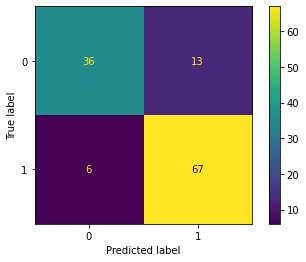

In [15]:
# looking at a confusion matrix

preds = np.argmax(preds_output.predictions, axis=1)
labels = np.array(preds_output.label_ids)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

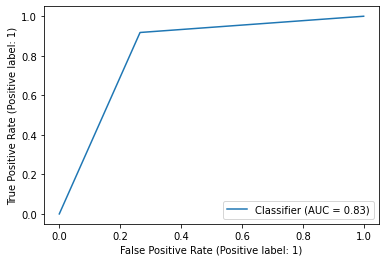

In [16]:
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(labels, preds)